In [81]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import skimpy as sk
import plotly.express as px
import scipy.stats as ss
import statsmodels.tsa as st
import mlflow
import mlflow.sklearn
import econml
import causalml
from dowhy import CausalModel
import shap
import dowhy
from pyngrok import ngrok
from warnings import filterwarnings; filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from scipy.stats import wilcoxon
from statsmodels.stats.contingency_tables import mcnemar

from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#Just in case 
from sklearn.ensemble import VotingClassifier

import joblib

In [22]:
train_df = pd.read_csv("Data/train.csv").apply(pd.to_numeric, errors="coerce").drop(columns=["Stock code"], axis=1)
train_df

Z-SCORE  Share pledge ratio of controlling shareholders  \
0      2.420039                                        0.152395   
1      3.844693                                        0.608351   
2      4.975553                                        0.499388   
3      4.088897                                        0.000000   
4     14.464241                                        0.332566   
...         ...                                             ...   
1437   2.060600                                        1.000000   
1438   1.593100                                        1.000000   
1439   4.175800                                        0.920500   
1440  15.781100                                        0.999100   
1441   2.759900                                        1.000000   

      Pledge ratio of limited sale shares  Pledge ratio of unlimited shares  \
0                                0.000000                          0.126366   
1                                0.014874                          0.159443   
2                                0.000000                          0.153660   
3                                0.000000                          0.001285   
4                                0.232977                          0.014730   
...                                   ...                               ...   
1437                             0.000000                          0.310900   
1438                             0.000000                          0.518900   
1439                             0.000000                          0.312400   
1440                             0.000000                          0.000000   
1441                             0.000000                          0.000000   

      Stock Volatility   P/E ratio  P/B ratio  \
0            49.318786   31.406188   3.658663   
1            48.390237   30.422921   5.460896   
2            46.639579  106.732585   3.636306   
3            31.025124   12.819830   3.392250   
4            41.572718   94.022181  65.671415   
...                ...         ...        ...   
1437         74.819300   47.170900   3.960000   
1438         79.732600  113.699800   1.820000   
1439         50.533400   80.590900   3.900000   
1440         66.668300  168.083500  12.510000   
1441         34.637500   21.588500   1.390000   

      Stock price rise and fall in the last year  Annual turnover rate  ST  \
0                                      -0.366077              1.420614   0   
1                                      -0.133857              2.676361   0   
2                                      -0.304963              5.589544   0   
3                                       0.906496              2.538287   0   
4                                       0.986821              3.692384   0   
...                                          ...                   ...  ..   
1437                                   -0.093700             12.870000   0   
1438                                    0.406900             11.300000   0   
1439                                    0.244900              5.440000   0   
1440                                    0.247800             10.350000   0   
1441                                   -0.317600              1.690000   0   

      ...  Proportion of independent directors  \
0     ...                             0.428571   
1     ...                             0.428571   
2     ...                             0.400000   
3     ...                             0.400000   
4     ...                             0.428571   
...   ...                                  ...   
1437  ...                             0.375000   
1438  ...                             0.428571   
1439  ...                             0.428571   
1440  ...                             0.428571   
1441  ...                             0.428571   

      Equity checks and balances (2-5 large/1 large)  \
0                                           0.558561   
1              

In [24]:
imputer = SimpleImputer()

train_df["P/E ratio"] = imputer.fit_transform(train_df[["P/E ratio"]])

In [4]:
sk.skim(train_df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1442   │ │ float64     │ 44    │                                                          │
│ │ Number of columns │ 55     │ │ int64       │ 9     │                                                          │
│ └───────────────────┴────────┘ │ string      │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column      ┃ NA ┃ NA % ┃ mean     ┃ sd      ┃ p0      ┃ p25      ┃ p50        ┃ p75     ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ Z-SCORE     │  0 │    0 │    6.388 │   13.06 │  -35.72 │    1.946 │      3.375 │   6.507 │  350.6 │   █    │  │
│ │ Share       │  0 │    0 │   0.4426 │  0.3451 │       0 │   0.0987 │     0.4404 │  0.7343 │      1 │ █▃▄▄▃▅ │  │
│ │ pledge      │    │      │          │         │         │          │            │         │        │        │  │
│ │ ratio of    │    │      │          │         │         │          │            │         │        │        │  │
│ │ controlling │    │      │          │         │         │          │            │         │        │        │  │
│ │ shareholder │    │      │          │         │         │          │            │         │        │        │  │
│ │ s           │    │      │          │         │         │          │            │         │        │        │  │
│ │ Pledge      │  0 │    0 │  0.02396 │ 0.08012 │       0 │        0 │          0 │       0 │ 0.7599 │   █    │  │
│ │ ratio of    │    │      │          │         │         │          │            │         │        │        │  │
│ │ limited     │    │      │          │         │         │          │            │         │        │        │  │
│ │ sale shares │    │      │          │         │         │          │            │         │        │        │  │
│ │ Pledge      │  0 │    0 │   0.1082 │  0.1338 │       0 │        0 │    0.05473 │  0.1863 │ 0.7063 │  █▃▂▁  │  │
│ │ ratio of    │    │      │          │         │         │          │            │         │        │        │  │
│ │ unlimited   │    │      │          │         │         │          │            │         │        │        │  │
│ │ shares      │    │      │          │         │         │          │            │         │        │        │  │
│ │ Stock       │  0 │    0 │    47.79 │   30.81 │       0 │    33.49 │      44.07 │    56.1 │  349.7 │   █▂   │  │
│ │ Volatility  │    │      │          │         │         │          │            │         │        │        │  │
│ │ P/B ratio   │  0 │    0 │    4.996 │   37.64 │  -388.4 │    1.684 │       2.78 │     4.8 │   1330 │    █   │  │
│ │ Stock price │  0 │    0 │   0.1666 │   0.811 │ -0.8979 │  -0.2511 │ -0.0008765 │  0.2648 │  8.561 │   █▁   │  │
│ │ rise and    │    │      │          │         │         │          │            │         │        │        │  │
│ │ fall in the │    │      │          │         │         │          │            │         │        │        │  │
│ │ last year   │    │      │          │         │      

In [23]:
train_df.isna().sum()

Z-SCORE                                                                                                                                                    0
Share pledge ratio of controlling shareholders                                                                                                             0
Pledge ratio of limited sale shares                                                                                                                        0
Pledge ratio of unlimited shares                                                                                                                           0
Stock Volatility                                                                                                                                           0
P/E ratio                                                                                                                                                  7
P/B ratio                                                 

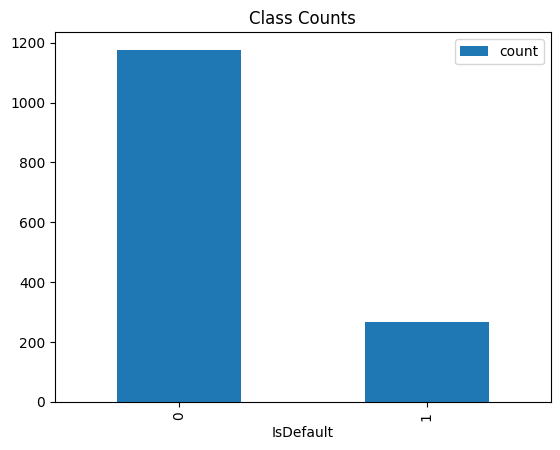

In [5]:
train_df["IsDefault"].value_counts().plot(kind="bar")
plt.title("Class Counts")
plt.legend()
#plt.savefig("Visualizations/Class Counts")
plt.show()

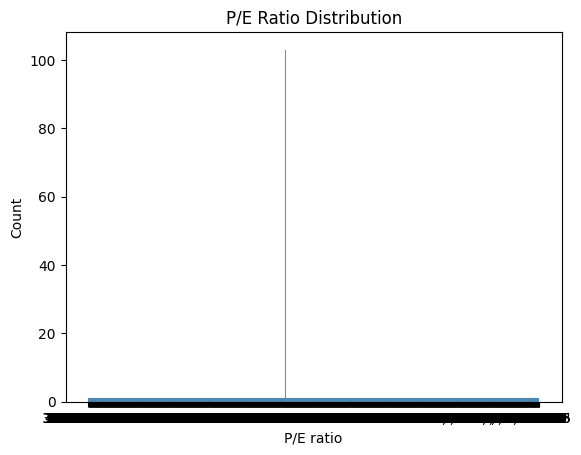

In [6]:
#P/E Ratio Distribution
sns.histplot(train_df["P/E ratio"])
plt.title("P/E Ratio Distribution")
#plt.savefig("Visualizations/PE Ratio Distribution")
plt.show()

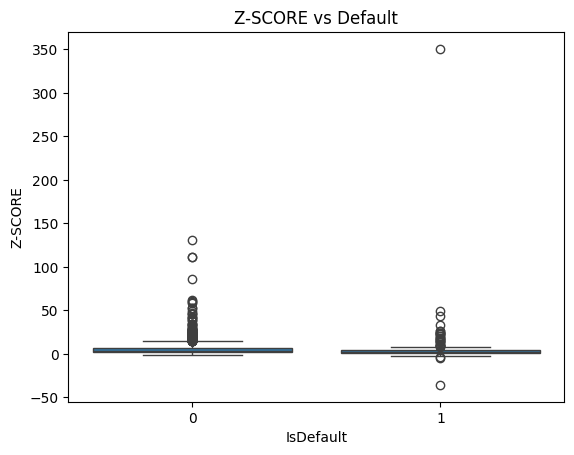

In [7]:
#Financial Distress Detector
plt.figure()
sns.boxplot(x="IsDefault", y="Z-SCORE", data=train_df)
plt.title("Z-SCORE vs Default")
#plt.savefig("Visualizations/Z-SCORE vs Default")
plt.show()

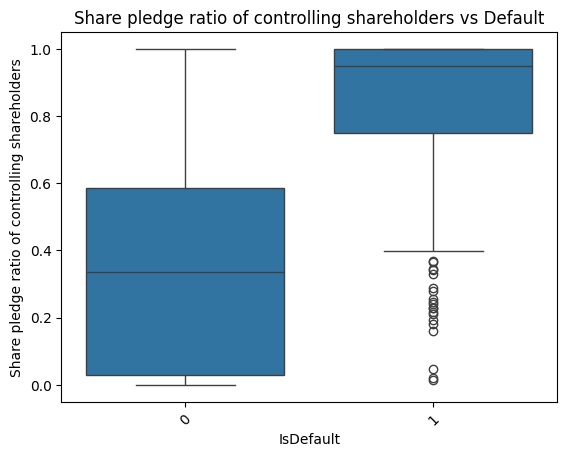

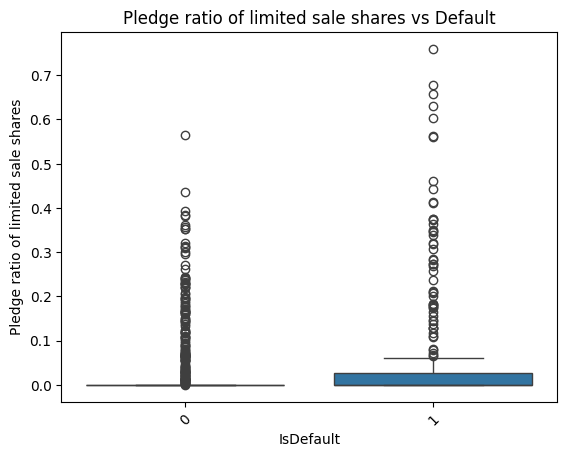

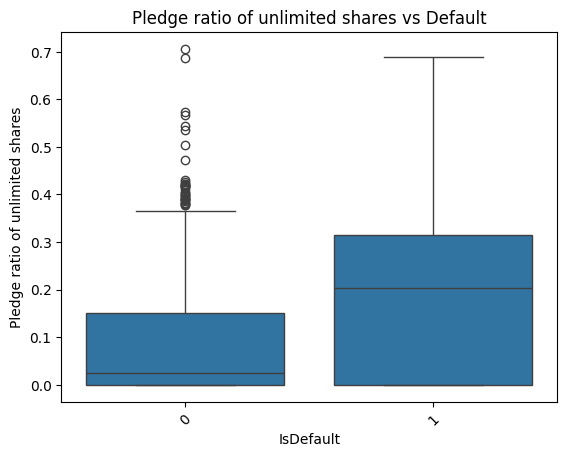

In [8]:
#Stock Pledge to detect signs of default
pledge_cols = [
    "Share pledge ratio of controlling shareholders",
    "Pledge ratio of limited sale shares",
    "Pledge ratio of unlimited shares"
]

for col in pledge_cols:
    plt.figure()
    sns.boxplot(x="IsDefault", y=col, data=train_df)
    plt.title(f"{col} vs Default")
    plt.xticks(rotation=45)
    #plt.savefig(f"{col}")
    plt.show()

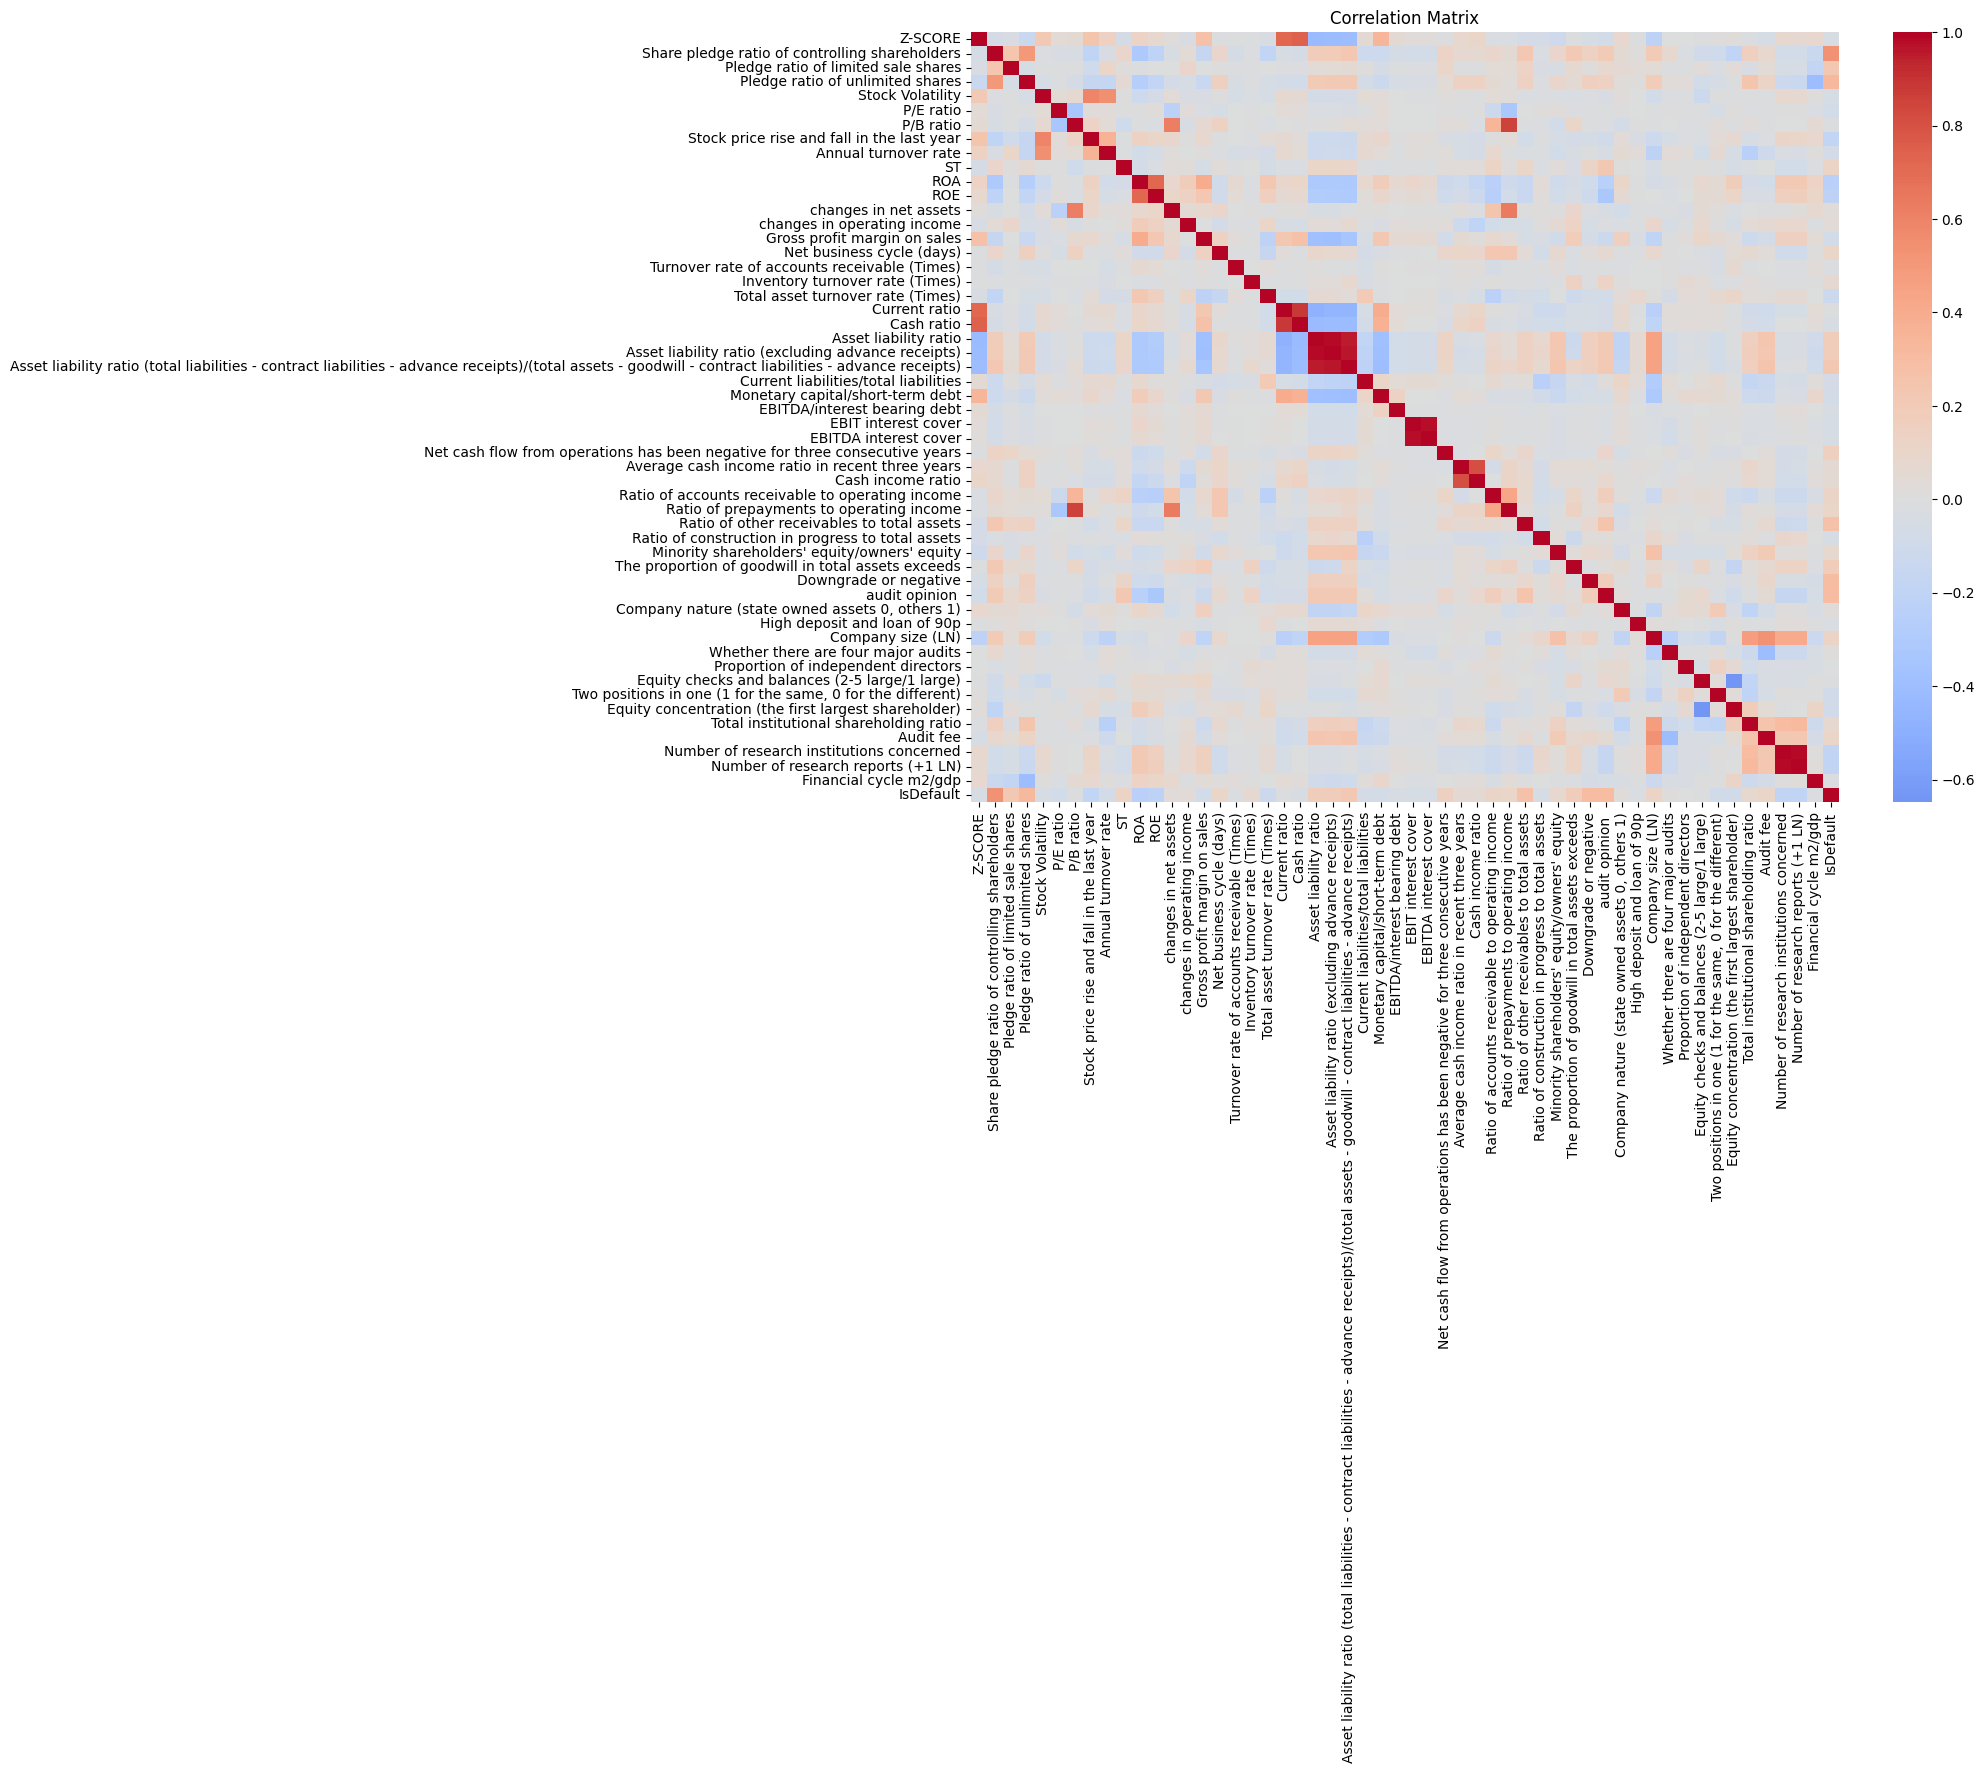

In [9]:
#Correlations
numeric_df = (
    train_df
    .drop(columns=["Stock code"])
    .replace(",", "", regex=True)
    .apply(pd.to_numeric, errors="coerce")
)


plt.figure(figsize=(14, 10))
sns.heatmap(
    numeric_df.corr(),
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Matrix")
#plt.savefig("Visualizations/Correlation Matrix")
plt.show()

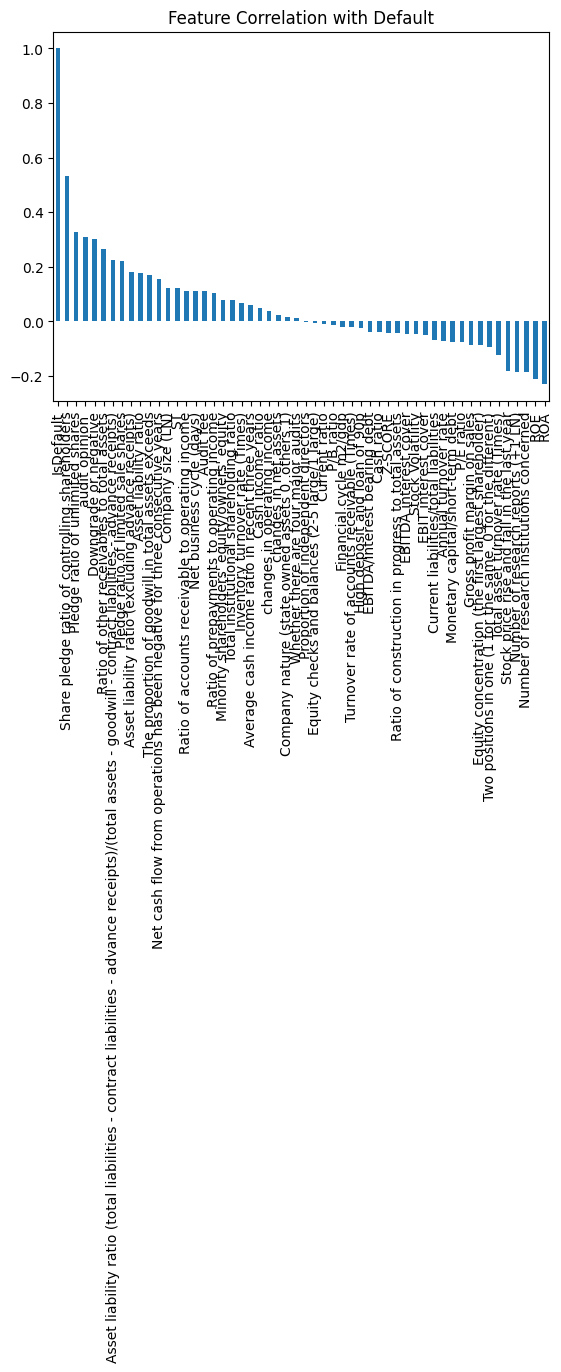

In [15]:
corr_with_target = numeric_df.corr()["IsDefault"].sort_values(ascending=False)

plt.figure()
corr_with_target.plot(kind="bar")
plt.title("Feature Correlation with Default")
#plt.savefig("Visualizations/Feature Correlation with Default")
plt.show()

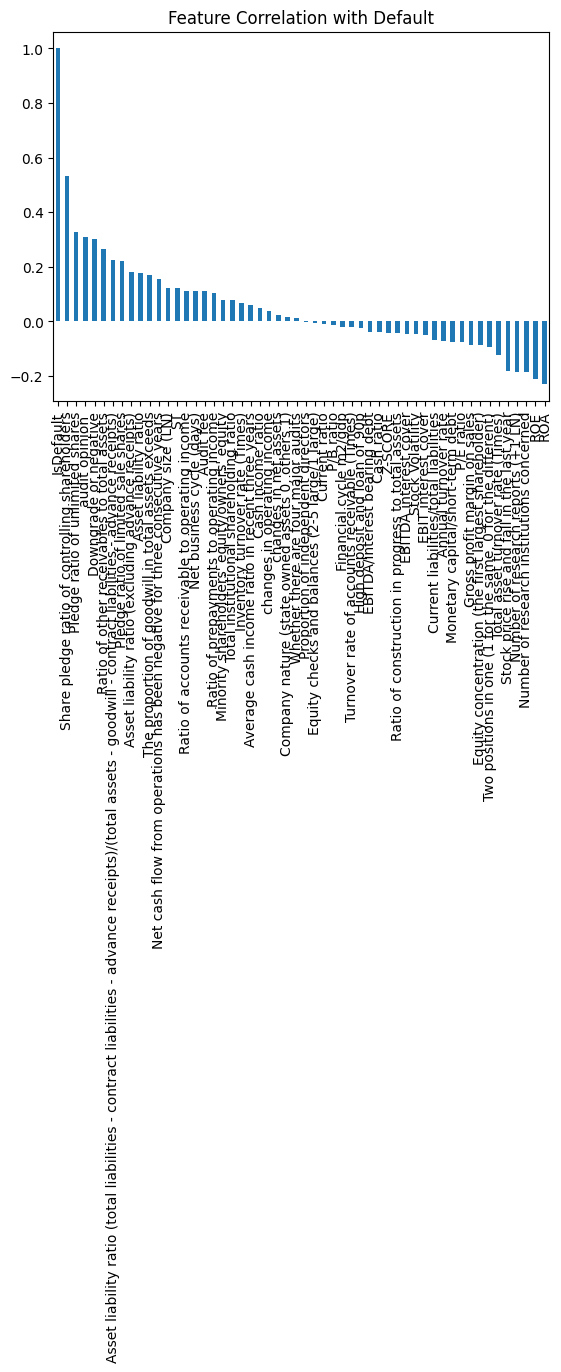

In [10]:
#Top Correlations
corr_with_target = numeric_df.corr()["IsDefault"].sort_values(ascending=False)

plt.figure()
corr_with_target.plot(kind="bar")
plt.title("Feature Correlation with Default")
plt.savefig("Visualizations/Feature Correlation with Default")
plt.show()

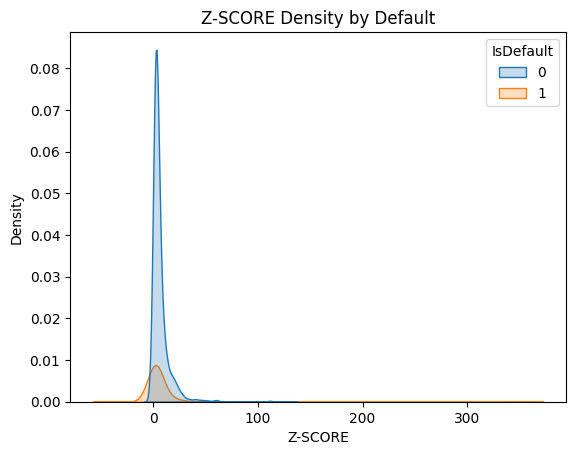

In [11]:
#Feature Importance
plt.figure()
sns.kdeplot(data=train_df, x="Z-SCORE", hue="IsDefault", fill=True)
plt.title("Z-SCORE Density by Default")
#plt.savefig("Visualizations/Z-SCORE Density by Default")
plt.show()

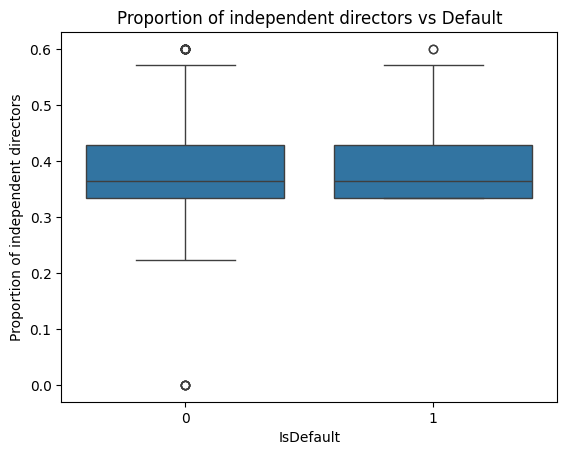

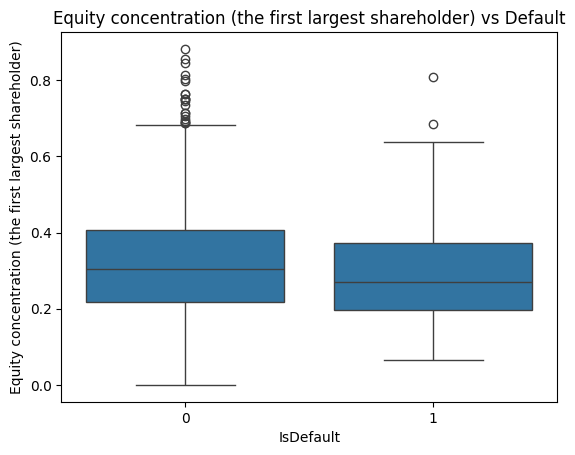

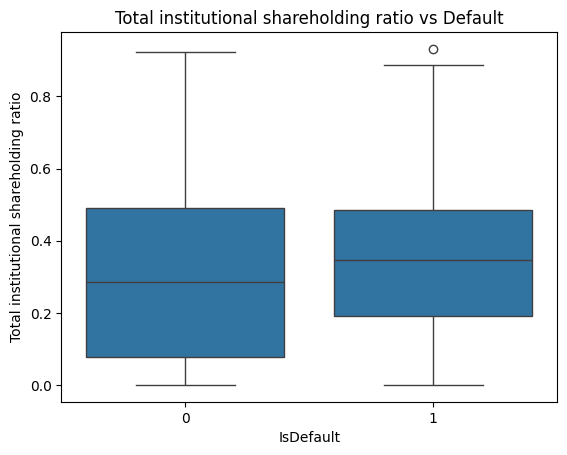

In [12]:
gov_cols = [
    "Proportion of independent directors",
    "Equity concentration (the first largest shareholder)",
    "Total institutional shareholding ratio"
]

for col in gov_cols:
    plt.figure()
    sns.boxplot(x="IsDefault", y=col, data=train_df)
    plt.title(f"{col} vs Default")
    #plt.savefig(f"Visualizations/{col} vs Default")
    plt.show()

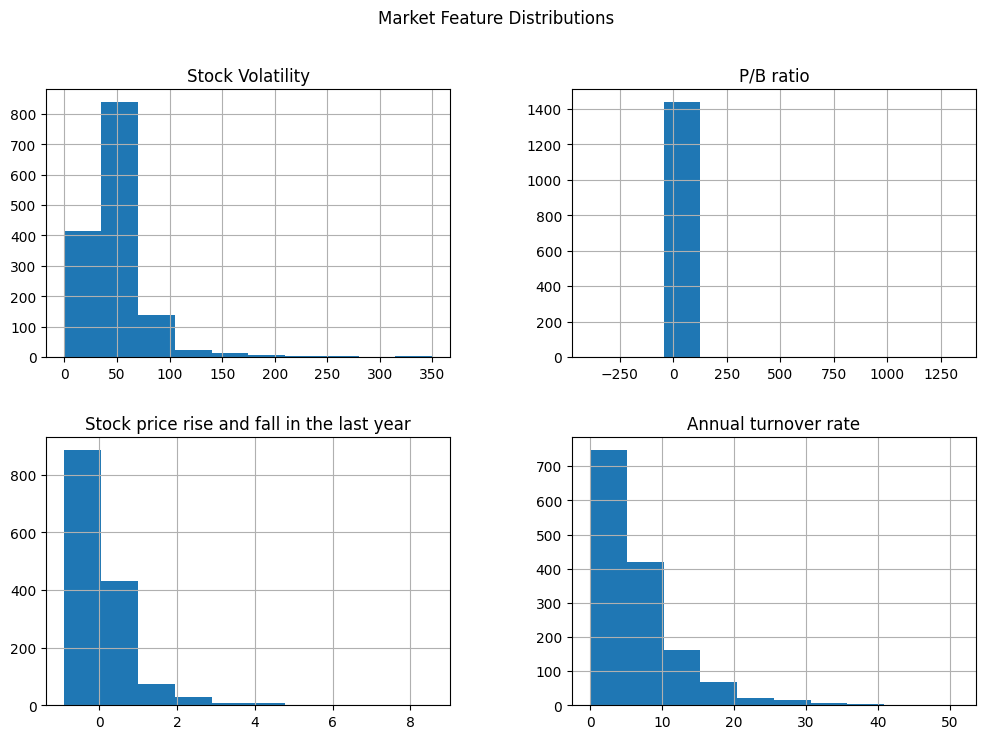

In [13]:
market_cols = [
    "Stock Volatility",
    "P/E ratio",
    "P/B ratio",
    "Stock price rise and fall in the last year",
    "Annual turnover rate"
]

train_df[market_cols].hist(figsize=(12, 8))
plt.suptitle("Market Feature Distributions")
#plt.savefig("Visualizations/Market Feature Distributions")
plt.show()

## Modelling

In [26]:
X = train_df.drop(columns=["IsDefault"], axis=1)
y = train_df["IsDefault"]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

smote = SMOTE()

X_train, Y_train = smote.fit_resample(X_train, Y_train)

In [30]:
#Models
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        max_iter=500,
        random_state=42
    ))
])

rfc = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features = "sqrt",
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    ))
])

gbc = Pipeline([
    ("scaler", StandardScaler()),
    ("model", GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        max_depth=3,
        subsample=0.8,
        min_samples_leaf=5,
        random_state=42
    ))
])

xgb = Pipeline([
    ("scaler", StandardScaler()),
    ("model", XGBClassifier(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,     # L1
        reg_lambda=1.0,    # L2
        min_child_weight=5,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss"
    ))
])

lgbm = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LGBMClassifier(
        n_estimators=500,
        learning_rate=0.03,
        num_leaves=31,      # critical parameter
        max_depth=-1,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42
    ))
])


cb = Pipeline([
    ("scaler", StandardScaler()),
    ("model", CatBoostClassifier(
        iterations=500,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=3,
        subsample=0.8,
        random_state=42,
        verbose=0
    ))
])


In [31]:
#Training
models = {
    "Logistic Regression": lr,
    "Random Forest Classifier": rfc,
    "Gradient Boosting Classifier": gbc,
    "XGBClassifier": xgb,
    "LGBClassifier": lgbm,
    "CatBoostClassifier": cb
}

EXPERIMENT_NAME = "Stock_Default_2026_MultiModel"
mlflow.set_experiment(EXPERIMENT_NAME)
N_SPLITS = 5
RANDOM_STATE = 42

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

for model_name, pipeline in models.items():
    with mlflow.start_run(run_name=model_name):
        print(f"Training {model_name}...")

        auc_scores = []
        f1_scores = []
        acc_scores = []

        # Stratified K-Fold CV
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            pipeline.fit(X_train, y_train)

            y_pred = pipeline.predict(X_val)
            y_proba = pipeline.predict_proba(X_val)[:, 1]

            auc = roc_auc_score(y_val, y_proba)
            f1 = f1_score(y_val, y_pred)
            acc = accuracy_score(y_val, y_pred)

            auc_scores.append(auc)
            f1_scores.append(f1)
            acc_scores.append(acc)

            print(f"  Fold {fold+1}: AUC={auc:.4f}, F1={f1:.4f}, Accuracy={acc:.4f}")

        # CV Summary
        print(f"{model_name} CV Mean Scores:")
        print(f"  Mean AUC: {np.mean(auc_scores):.4f}")
        print(f"  Mean F1: {np.mean(f1_scores):.4f}")
        print(f"  Mean Accuracy: {np.mean(acc_scores):.4f}\n")

        # Log CV Metrics
        mlflow.log_metric("AUC_mean", np.mean(auc_scores))
        mlflow.log_metric("F1_mean", np.mean(f1_scores))
        mlflow.log_metric("Accuracy_mean", np.mean(acc_scores))

        
        pipeline.fit(X, y)
        y_pred_full = pipeline.predict(X)
        cm = confusion_matrix(y, y_pred_full)

        plt.figure()
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title(f"{model_name} Confusion Matrix")
        cm_file = f"{model_name}_confusion_matrix.png"
        plt.savefig(cm_file)
        plt.close()
        mlflow.log_artifact(cm_file)

        
        y_proba_full = pipeline.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_proba_full)

        plt.figure()
        plt.plot(fpr, tpr)
        plt.title(f"{model_name} ROC Curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        roc_file = f"{model_name}_roc_curve.png"
        plt.savefig(roc_file)
        plt.close()
        mlflow.log_artifact(roc_file)

        
        if model_name in ["Random Forest Classifier", "Gradient Boosting Classifier", "XGBClassifier", "LGBClassifier"]:
            param_name = "model__n_estimators"
            param_range = [100, 300, 500, 700]

            train_scores, val_scores = validation_curve(
                pipeline,
                X, y,
                param_name=param_name,
                param_range=param_range,
                cv=3,
                scoring="roc_auc"
            )

            plt.figure()
            plt.plot(param_range, np.mean(train_scores, axis=1), label="Train AUC")
            plt.plot(param_range, np.mean(val_scores, axis=1), label="Validation AUC")
            plt.xlabel(param_name)
            plt.ylabel("ROC-AUC")
            plt.title(f"{model_name} Validation Curve")
            plt.legend()
            val_file = f"{model_name}_validation_curve.png"
            plt.savefig(val_file)
            plt.close()
            mlflow.log_artifact(val_file)

        
        mlflow.log_params(pipeline.named_steps["model"].get_params())
        mlflow.sklearn.log_model(pipeline, f"{model_name}_model")

        print(f"{model_name} completed and logged to MLflow.\n")

2026/02/26 22:12:41 INFO mlflow.tracking.fluent: Experiment with name 'Stock_Default_2026_MultiModel' does not exist. Creating a new experiment.


Training Logistic Regression...
  Fold 1: AUC=0.9208, F1=0.7234, Accuracy=0.9100
  Fold 2: AUC=0.9077, F1=0.6931, Accuracy=0.8927
  Fold 3: AUC=0.9363, F1=0.7290, Accuracy=0.8993
  Fold 4: AUC=0.9011, F1=0.6292, Accuracy=0.8854
  Fold 5: AUC=0.9059, F1=0.5909, Accuracy=0.8750
Logistic Regression CV Mean Scores:
  Mean AUC: 0.9144
  Mean F1: 0.6731
  Mean Accuracy: 0.8925



2026/02/26 22:12:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 22:13:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression completed and logged to MLflow.

Training Random Forest Classifier...
  Fold 1: AUC=0.9613, F1=0.7692, Accuracy=0.9273
  Fold 2: AUC=0.9796, F1=0.7416, Accuracy=0.9204
  Fold 3: AUC=0.9693, F1=0.8211, Accuracy=0.9410
  Fold 4: AUC=0.9473, F1=0.6824, Accuracy=0.9062
  Fold 5: AUC=0.9530, F1=0.6977, Accuracy=0.9097
Random Forest Classifier CV Mean Scores:
  Mean AUC: 0.9621
  Mean F1: 0.7424
  Mean Accuracy: 0.9209



2026/02/26 22:14:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 22:15:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest Classifier completed and logged to MLflow.

Training Gradient Boosting Classifier...
  Fold 1: AUC=0.9993, F1=0.9709, Accuracy=0.9896
  Fold 2: AUC=0.9992, F1=0.9725, Accuracy=0.9896
  Fold 3: AUC=0.9995, F1=0.9808, Accuracy=0.9931
  Fold 4: AUC=0.9992, F1=0.9608, Accuracy=0.9861
  Fold 5: AUC=0.9999, F1=0.9905, Accuracy=0.9965
Gradient Boosting Classifier CV Mean Scores:
  Mean AUC: 0.9994
  Mean F1: 0.9751
  Mean Accuracy: 0.9910



2026/02/26 22:18:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 22:18:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Gradient Boosting Classifier completed and logged to MLflow.

Training XGBClassifier...
  Fold 1: AUC=0.9950, F1=0.9400, Accuracy=0.9792
  Fold 2: AUC=0.9969, F1=0.9126, Accuracy=0.9689
  Fold 3: AUC=0.9965, F1=0.9615, Accuracy=0.9861
  Fold 4: AUC=0.9967, F1=0.9184, Accuracy=0.9722
  Fold 5: AUC=0.9874, F1=0.9307, Accuracy=0.9757
XGBClassifier CV Mean Scores:
  Mean AUC: 0.9945
  Mean F1: 0.9326
  Mean Accuracy: 0.9764



2026/02/26 22:19:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 22:19:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBClassifier completed and logged to MLflow.

Training LGBClassifier...
[LightGBM] [Info] Number of positive: 213, number of negative: 940
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10234
[LightGBM] [Info] Number of data points in the train set: 1153, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184735 -> initscore=-1.484588
[LightGBM] [Info] Start training from score -1.484588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

2026/02/26 22:19:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 22:20:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LGBClassifier completed and logged to MLflow.

Training CatBoostClassifier...
  Fold 1: AUC=0.9986, F1=0.9608, Accuracy=0.9862
  Fold 2: AUC=0.9992, F1=0.9320, Accuracy=0.9758
  Fold 3: AUC=0.9998, F1=0.9808, Accuracy=0.9931
  Fold 4: AUC=0.9996, F1=0.9608, Accuracy=0.9861
  Fold 5: AUC=0.9995, F1=0.9623, Accuracy=0.9861
CatBoostClassifier CV Mean Scores:
  Mean AUC: 0.9994
  Mean F1: 0.9593
  Mean Accuracy: 0.9854



2026/02/26 22:20:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 22:20:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


CatBoostClassifier completed and logged to MLflow.



In [33]:
#Ensembling Via Voting Classifier
ensemble = VotingClassifier(
    estimators=[(name, pipeline) for name, pipeline in models.items()],
    voting='soft',# use probabilities for better ROC-AUC
    n_jobs=-1
)

EXPERIMENT_NAME = "Stock_Default_2026_VotingEnsemble"
mlflow.set_experiment(EXPERIMENT_NAME)
N_SPLITS = 5
RANDOM_STATE = 42

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

with mlflow.start_run(run_name="Voting_Ensemble"):

    print("Training Voting Ensemble...")

    auc_scores = []
    f1_scores = []
    acc_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        ensemble.fit(X_train, y_train)

        y_pred = ensemble.predict(X_val)
        y_proba = ensemble.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_proba)
        f1 = f1_score(y_val, y_pred)
        acc = accuracy_score(y_val, y_pred)

        auc_scores.append(auc)
        f1_scores.append(f1)
        acc_scores.append(acc)

        print(f"  Fold {fold+1}: AUC={auc:.4f}, F1={f1:.4f}, Accuracy={acc:.4f}")

    # CV Summary
    print("Voting Ensemble CV Mean Scores:")
    print(f"  Mean AUC: {np.mean(auc_scores):.4f}")
    print(f"  Mean F1: {np.mean(f1_scores):.4f}")
    print(f"  Mean Accuracy: {np.mean(acc_scores):.4f}\n")

    # Log CV metrics
    mlflow.log_metric("AUC_mean", np.mean(auc_scores))
    mlflow.log_metric("F1_mean", np.mean(f1_scores))
    mlflow.log_metric("Accuracy_mean", np.mean(acc_scores))

    
    ensemble.fit(X, y)
    y_pred_full = ensemble.predict(X)
    cm = confusion_matrix(y, y_pred_full)

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Voting Ensemble Confusion Matrix")
    cm_file = "Voting_Ensemble_confusion_matrix.png"
    plt.savefig(cm_file)
    plt.close()
    mlflow.log_artifact(cm_file)

    
    y_proba_full = ensemble.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_proba_full)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.title("Voting Ensemble ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    roc_file = "Voting_Ensemble_roc_curve.png"
    plt.savefig(roc_file)
    plt.close()
    mlflow.log_artifact(roc_file)

    
    # Log each individual model params
    for name, pipeline in models.items():
        mlflow.log_params({f"{name}__{k}": v for k, v in pipeline.named_steps["model"].get_params().items()})

    mlflow.sklearn.log_model(ensemble, "Voting_Ensemble_model")

    print("Voting Ensemble completed and logged to MLflow.")
    

2026/02/26 22:27:06 INFO mlflow.tracking.fluent: Experiment with name 'Stock_Default_2026_VotingEnsemble' does not exist. Creating a new experiment.


Training Voting Ensemble...
[LightGBM] [Info] Number of positive: 213, number of negative: 940
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10234
[LightGBM] [Info] Number of data points in the train set: 1153, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184735 -> initscore=-1.484588
[LightGBM] [Info] Start training from score -1.484588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

2026/02/26 22:30:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 22:31:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Voting Ensemble completed and logged to MLflow.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [35]:
#saving all of the models via Joblib

# Saving individual models
for name, pipeline in models.items():
    print(f"Saving {name}...")
    joblib.dump(pipeline, f"{name}_model.pkl")  # pass the model object, not the filename string
    print(f"{name} model saved!")

# Saving the Voting Ensemble model
print("\nAlso saving the Voting Ensemble Model...")
joblib.dump(ensemble, "Voting_ensemble_model.pkl")
print("Ensemble saved!")

Saving Logistic Regression...
Logistic Regression model saved!
Saving Random Forest Classifier...
Random Forest Classifier model saved!
Saving Gradient Boosting Classifier...
Gradient Boosting Classifier model saved!
Saving XGBClassifier...
XGBClassifier model saved!
Saving LGBClassifier...
LGBClassifier model saved!
Saving CatBoostClassifier...
CatBoostClassifier model saved!

Also saving the Voting Ensemble Model...
Ensemble saved!


## Saving Via The Test Set

In [40]:
test_df = pd.read_csv("Data/test.csv").apply(pd.to_numeric, errors="coerce").drop(columns=["Stock code"], axis=1)

test_imputer = SimpleImputer()
test_df["P/E ratio"] = test_imputer.fit_transform(test_df[["P/E ratio"]])

X_test = test_df

In [41]:
X_test

Z-SCORE  Share pledge ratio of controlling shareholders  \
0    3.885559                                        0.423059   
1    4.005654                                        0.425968   
2    3.756955                                        0.421488   
3    4.594901                                        0.177552   
4    4.464198                                        0.183298   
..        ...                                             ...   
371  4.864247                                        1.000000   
372  4.918011                                        1.000000   
373  4.440092                                        1.000000   
374  4.125442                                        0.997472   
375  1.816345                                        1.000000   

     Pledge ratio of limited sale shares  Pledge ratio of unlimited shares  \
0                               0.001325                          0.000000   
1                               0.000000                          0.000000   
2                               0.001559                          0.000000   
3                               0.000170                          0.000000   
4                               0.000000                          0.000000   
..                                   ...                               ...   
371                             0.001179                          0.446631   
372                             0.000637                          0.446047   
373                             0.000000                          0.001655   
374                             0.000000                          0.001643   
375                             0.001807                          0.236501   

     Stock Volatility   P/E ratio  P/B ratio  \
0           22.708717  266.942999   1.456945   
1           21.725510  267.509828   2.363837   
2           21.814935  268.215693   1.365815   
3           29.294586   12.655105   2.207722   
4           29.059476   17.751335   1.270111   
..                ...         ...        ...   
371         34.088829   36.630376   1.968563   
372         33.891888   38.507243   1.321819   
373         34.671966   19.597310   3.595612   
374         88.019169   53.022477   8.371512   
375         43.485692   38.677718   2.357014   

     Stock price rise and fall in the last year  Annual turnover rate  ST  \
0                                      0.400305              3.908013   0   
1                                      0.406924              3.793922   0   
2                                      0.413868              3.823045   0   
3                                     -0.018485              2.328000   0   
4                                      0.000974              2.212985   0   
..                                          ...                   ...  ..   
371                                   -0.001148              2.274894   0   
372                                    0.019625              2.198735   0   
373                                    0.026597              3.675756   0   
374                                    1.152649              9.816097   0   
375                                   -0.121273              4.960616   0   

     ...  Whether there are four major audits  \
0    ...                                    1   
1    ...                                    1   
2    ...                                    1   
3    ...                                    1   
4    ...                                    1   
..   ...                                  ...   
371  ...                                    1   
372  ...                                    1   
373  ...                                    1   
374  ...                                    1   
375  ...                                    1   

     Proportion of independent directors  \
0                               0.333731   
1                               0.333141   
2                               0.333731   
3                    

In [43]:
#Just To get the stock_codes
new_test_df = pd.read_csv("Data/test.csv")

In [44]:
final_preds = ensemble.predict(X_test)

submission = pd.DataFrame({
    "Stock code": new_test_df["Stock code"],
    "isDefault": final_preds
})

submission.to_csv("submission.csv", index=False)

## Statistical Test

In [49]:
#Reinitializing the splits
X = train_df.drop("IsDefault", axis=1)
y = train_df["IsDefault"]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [53]:
def cliffs_delta(x, y):
    n1, n2 = len(x), len(y)
    more = sum([1 for i in x for j in y if i > j])
    less = sum([1 for i in x for j in y if i < j])
    delta = (more - less) / (n1 * n2)
    return delta


def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstrap=1000, alpha=0.05):
    boot_metrics = []
    for _ in range(n_bootstrap):
        idxs = resample(range(len(y_true)))
        y_true_boot = y_true[idxs]
        y_pred_boot = y_pred[idxs]
        boot_metrics.append(metric_fn(y_true_boot, y_pred_boot))
    lower = np.percentile(boot_metrics, 100*alpha/2)
    upper = np.percentile(boot_metrics, 100*(1-alpha/2))
    return lower, upper


def statistical_analysis(y_true, y_pred_dict):
    """
    y_true: true labels (np.array)
    y_pred_dict: dict of model_name -> predicted labels (np.array)
    """
    print("\n===== STATISTICAL ANALYSIS =====\n")
    
    model_names = list(y_pred_dict.keys())
    n_models = len(model_names)
    
    
    print("=== McNemar Test ===")
    for i in range(n_models):
        for j in range(i+1, n_models):
            pred1 = y_pred_dict[model_names[i]]
            pred2 = y_pred_dict[model_names[j]]
        
            table = confusion_matrix(pred1 == y_true, pred2 == y_true)
            if table.shape != (2,2):
                # force 2x2 contingency table
                table2x2 = np.zeros((2,2))
                for a in [0,1]:
                    for b in [0,1]:
                        table2x2[a,b] = np.sum(((pred1 == y_true) == a) & ((pred2 == y_true) == b))
                table = table2x2
            result = mcnemar(table, exact=True)
            print(f"{model_names[i]} vs {model_names[j]}: p-value={result.pvalue:.4f}")
    
    
    
    metrics = ["accuracy", "f1"]
    print("\n=== Wilcoxon Signed-Rank Test ===")
    for i in range(n_models):
        for j in range(i+1, n_models):
            correct_i = (y_pred_dict[model_names[i]] == y_true).astype(int)
            correct_j = (y_pred_dict[model_names[j]] == y_true).astype(int)
            stat, p = wilcoxon(correct_i, correct_j)
            print(f"{model_names[i]} vs {model_names[j]}: p-value={p:.4f}")
                
   
    print("\n=== Cliff's Delta ===")
    for i in range(n_models):
        for j in range(i+1, n_models):
            delta = cliffs_delta(y_pred_dict[model_names[i]], y_pred_dict[model_names[j]])
            print(f"{model_names[i]} vs {model_names[j]}: delta={delta:.4f}")
    
    
    print("\n=== Cross-Entropy Loss Distribution & Bootstrap CI ===")
    for name, y_pred in y_pred_dict.items():
        cce = log_loss(y_true, y_pred) if y_pred.ndim==1 else log_loss(y_true, y_pred)
        ci_lower, ci_upper = bootstrap_ci(log_loss, y_true, y_pred)
        print(f"{name}: CCE={cce:.4f}, 95% CI=({ci_lower:.4f},{ci_upper:.4f})")
    
    
    print("\n=== ROC-AUC ===")
    for name, y_pred in y_pred_dict.items():
        try:
            auc = roc_auc_score(y_true, y_pred)
        except:
            # fallback for binary predictions
            auc = roc_auc_score(y_true, y_pred_dict[name])
        print(f"{name}: ROC-AUC={auc:.4f}")
        
    

In [54]:
# Collect predictions
y_pred_dict = {}

# Individual models
for name, model in models.items():
    y_pred_dict[name] = model.predict(X_test)

# Voting ensemble
y_pred_dict["Voting_Ensemble"] = ensemble.predict(X_test)

# Run statistical analysis
statistical_analysis(y_true=Y_test.values, y_pred_dict=y_pred_dict)


===== STATISTICAL ANALYSIS =====

=== McNemar Test ===
Logistic Regression vs Random Forest Classifier: p-value=0.0072
Logistic Regression vs Gradient Boosting Classifier: p-value=0.0000
Logistic Regression vs XGBClassifier: p-value=0.0000
Logistic Regression vs LGBClassifier: p-value=0.0000
Logistic Regression vs CatBoostClassifier: p-value=0.0000
Logistic Regression vs Voting_Ensemble: p-value=0.0000
Random Forest Classifier vs Gradient Boosting Classifier: p-value=0.0010
Random Forest Classifier vs XGBClassifier: p-value=0.0010
Random Forest Classifier vs LGBClassifier: p-value=0.0010
Random Forest Classifier vs CatBoostClassifier: p-value=0.0010
Random Forest Classifier vs Voting_Ensemble: p-value=0.0010
Gradient Boosting Classifier vs XGBClassifier: p-value=1.0000
Gradient Boosting Classifier vs LGBClassifier: p-value=1.0000
Gradient Boosting Classifier vs CatBoostClassifier: p-value=1.0000
Gradient Boosting Classifier vs Voting_Ensemble: p-value=1.0000
XGBClassifier vs LGBClassi

## Stress Testing

In [59]:
def feature_perturbation_test(model, X_test, features, perturb_pct=0.1, n_trials=50):
    """
    Stress test by perturbing features.
    """
    X_test = X_test.copy()
    probs_list = []
    
    for trial in range(n_trials):
        X_perturbed = X_test.copy()
        for feat in features:
            noise = np.random.uniform(-perturb_pct, perturb_pct, size=X_test.shape[0])
            X_perturbed[feat] = X_perturbed[feat] * (1 + noise)
        
        probs = model.predict_proba(X_perturbed)[:,1]  # prob of default
        probs_list.append(probs)
    
    probs_array = np.array(probs_list)
    # mean & std deviation per sample
    mean_probs = probs_array.mean(axis=0)
    std_probs = probs_array.std(axis=0)
    
    plt.figure(figsize=(8,5))
    plt.hist(std_probs, bins=30)
    plt.title(f"Prediction Sensitivity (Std. Dev) over {n_trials} Perturbations")
    plt.xlabel("Std Dev of Predicted Probability")
    plt.ylabel("Number of Samples")
    plt.savefig(f"Prediction Sensitivity (Std. Dev) over {n_trials} Perturbations.png")
    plt.show()
    
    return mean_probs, std_probs

In [56]:
def adversarial_scenario(model, X_test, scenario_dict):
    X_adv = X_test.copy()
    for feat, change in scenario_dict.items():
        X_adv[feat] = X_adv[feat] * (1 + change)
    preds = model.predict(X_adv)
    probs = model.predict_proba(X_adv)[:,1]
    return preds, probs

In [57]:
def feature_ablation_per_model(models, X_test, y_test):
    """
    Run feature ablation test for each model.
    Prints accuracy drop when each feature is removed.
    """
    ablation_results = {}

    for name, model in models.items():
        print(f"\n=== Feature Ablation: {name} ===")
        base_acc = accuracy_score(y_test, model.predict(X_test))
        print(f"Base Accuracy: {base_acc:.4f}")
        ablation_results[name] = {}

        for feat in X_test.columns:
            X_ablate = X_test.drop(columns=[feat])
            try:
                # Make sure model can handle input
                acc = accuracy_score(y_test, model.predict(X_ablate))
                delta = acc - base_acc
                print(f"Drop '{feat}': Accuracy={acc:.4f} Δ={delta:.4f}")
                ablation_results[name][feat] = delta
            except Exception as e:
                print(f"Cannot drop '{feat}': {str(e)}")
                ablation_results[name][feat] = None

    return ablation_results

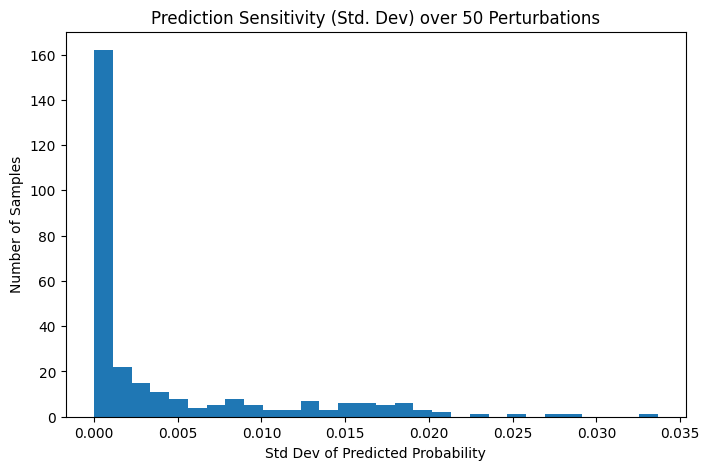

Default predictions under stress: 0.18339100346020762

=== Feature Ablation: Logistic Regression ===
Base Accuracy: 0.9170
Cannot drop 'Z-SCORE': The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Z-SCORE

Cannot drop 'Share pledge ratio of controlling shareholders': The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Share pledge ratio of controlling shareholders

Cannot drop 'Pledge ratio of limited sale shares': The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Pledge ratio of limited sale shares

Cannot drop 'Pledge ratio of unlimited shares': The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Pledge ratio of unlimited shares

Cannot drop 'Stock Volatility': The feature names should match those that were passed during fit.

In [60]:
features_to_perturb = ["P/E ratio", "Stock Volatility", "Share pledge ratio of controlling shareholders"]
mean_probs, std_probs = feature_perturbation_test(ensemble, X_test, features_to_perturb, perturb_pct=0.1)

scenario = {
    "Stock price rise and fall in the last year": -0.3,
    "P/E ratio": 0.5,
    "Stock Volatility": 1.0,
    "Share pledge ratio of controlling shareholders": 0.2
}

preds, probs = adversarial_scenario(ensemble, X_test, scenario)
print("Default predictions under stress:", np.mean(preds))

ablation_results = feature_ablation_per_model(models, X_test, Y_test)
print(ablation_results)

## Impossibility Testing

In [63]:
def impossibility_testing(models, X_test, impossible_values_dict):
    """
    Run impossibility tests on models.
    Args:
        models: dict of trained models
        X_test: baseline dataframe
        impossible_values_dict: dict of feature: impossible_value
    Returns:
        results_df: dataframe with mean predicted probabilities per model
    """
    results = {}

    # Create impossible test dataframe
    X_impossible = X_test.copy()
    for feat, val in impossible_values_dict.items():
        if feat in X_impossible.columns:
            X_impossible[feat] = val

    for name, model in models.items():
        try:
            probs = model.predict_proba(X_impossible)[:,1]
            mean_prob = np.mean(probs)
            results[name] = mean_prob
            print(f"{name}: Mean predicted default under impossible conditions = {mean_prob:.4f}")
        except Exception as e:
            print(f"{name}: ERROR -> {str(e)}")
            results[name] = None

    # Convert to dataframe for plotting
    results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Mean Default Probability'])
    results_df.sort_values('Mean Default Probability', ascending=False, inplace=True)

    # Plot
    plt.figure(figsize=(10,5))
    plt.bar(results_df.index, results_df['Mean Default Probability'], color='crimson')
    plt.xticks(rotation=45)
    plt.ylabel("Mean Predicted Default Probability")
    plt.title("Impossibility Testing Across Models")
    plt.savefig("Impossibility Testing Across Models.png")
    plt.show()

    return results_df

Logistic Regression: Mean predicted default under impossible conditions = 0.0449
Random Forest Classifier: Mean predicted default under impossible conditions = 0.4202
Gradient Boosting Classifier: Mean predicted default under impossible conditions = 0.2182
XGBClassifier: Mean predicted default under impossible conditions = 0.3184
LGBClassifier: Mean predicted default under impossible conditions = 0.1982
CatBoostClassifier: Mean predicted default under impossible conditions = 0.2293


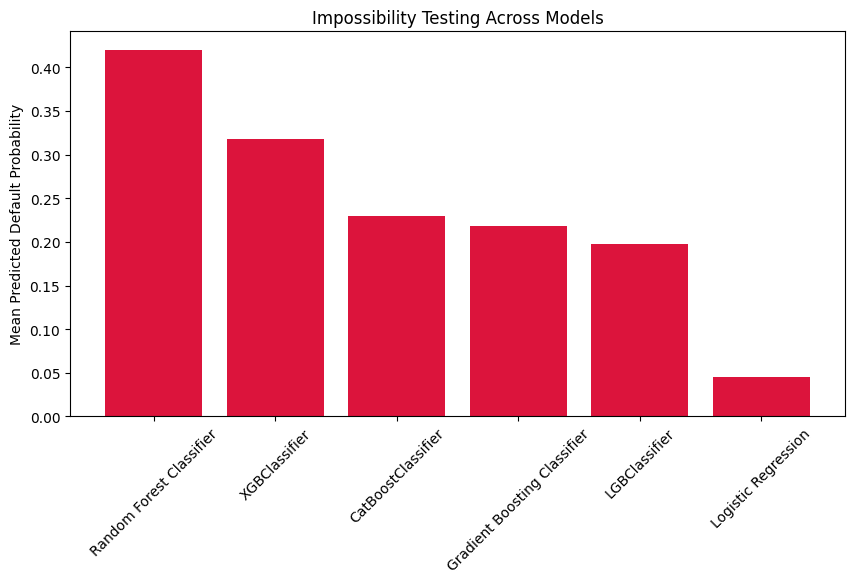

In [64]:
impossible_values = {
    "Stock Volatility": -0.5,
    "P/E ratio": -10,
    "Share pledge ratio of controlling shareholders": 1.5,
    "Stock price rise and fall in the last year": -5,
    "Annual turnover rate": 1000
}

impossibility_results = impossibility_testing(models, X_test, impossible_values)

## Model Interpretability

In [79]:
models = {
    "Logistic Regression": lr,
    "Random Forest Classifier": rfc,
    "Gradient Boosting Classifier": gbc,
    "XGBClassifier": xgb,
    "LGBClassifier": lgbm,
    "CatBoostClassifier": cb,
    "VotingClassifier": ensemble
}
# Create folder to save SHAP plots
os.makedirs("SHAP_Interpretability", exist_ok=True)


for model_name, model in models.items():
    print(f"\n=== SHAP Analysis for {model_name} ===")
    
    # Select explainer
    if "Logistic" in model_name:
        explainer = shap.LinearExplainer(model.named_steps["model"], X_train, feature_perturbation="interventional")
        shap_values = explainer.shap_values(X_test)
        expected_value = explainer.expected_value  # scalar
    elif "Voting" in model_name:
        # Surrogate for ensemble
        ensemble_preds = model.predict_proba(X_test)[:,1]
        from sklearn.tree import DecisionTreeRegressor
        surrogate = DecisionTreeRegressor(max_depth=3)
        surrogate.fit(X_test, ensemble_preds)
        explainer = shap.TreeExplainer(surrogate)
        shap_values = explainer.shap_values(X_test)
        expected_value = explainer.expected_value
    else:
        explainer = shap.TreeExplainer(model.named_steps["model"])
        shap_values = explainer.shap_values(X_test)
        # For binary classification tree models
        if isinstance(shap_values, list):
            shap_values = shap_values[1]      # class 1
            expected_value = explainer.expected_value[1]  # class 1

    # Global bar plot
    plt.figure(figsize=(12,6))
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False, max_display=20)
    bar_path = f"SHAP_Interpretability/{model_name}_shap_bar.png"
    plt.savefig(bar_path, bbox_inches="tight")
    plt.close()
    print(f"Saved global SHAP bar plot to {bar_path}")

    # Force plot for first sample
    shap.initjs()
    force_plot_path = f"SHAP_Interpretability/{model_name}_force_plot.html"
    # Use shap.plots.force with scalar expected_value and shap_values vector
    force_fig = shap.plots.force(expected_value, shap_values[0], matplotlib=False, show=False)
    shap.save_html(force_plot_path, force_fig)
    print(f"Saved force plot for first sample to {force_plot_path}")

print("\n✅ SHAP interpretability completed for all models and ensemble!")



=== SHAP Analysis for Logistic Regression ===
Saved global SHAP bar plot to SHAP_Interpretability/Logistic Regression_shap_bar.png


Saved force plot for first sample to SHAP_Interpretability/Logistic Regression_force_plot.html

=== SHAP Analysis for Random Forest Classifier ===
Saved global SHAP bar plot to SHAP_Interpretability/Random Forest Classifier_shap_bar.png


Saved force plot for first sample to SHAP_Interpretability/Random Forest Classifier_force_plot.html

=== SHAP Analysis for Gradient Boosting Classifier ===
Saved global SHAP bar plot to SHAP_Interpretability/Gradient Boosting Classifier_shap_bar.png


Saved force plot for first sample to SHAP_Interpretability/Gradient Boosting Classifier_force_plot.html

=== SHAP Analysis for XGBClassifier ===
Saved global SHAP bar plot to SHAP_Interpretability/XGBClassifier_shap_bar.png


Saved force plot for first sample to SHAP_Interpretability/XGBClassifier_force_plot.html

=== SHAP Analysis for LGBClassifier ===
Saved global SHAP bar plot to SHAP_Interpretability/LGBClassifier_shap_bar.png


Saved force plot for first sample to SHAP_Interpretability/LGBClassifier_force_plot.html

=== SHAP Analysis for CatBoostClassifier ===
Saved global SHAP bar plot to SHAP_Interpretability/CatBoostClassifier_shap_bar.png


Saved force plot for first sample to SHAP_Interpretability/CatBoostClassifier_force_plot.html

=== SHAP Analysis for VotingClassifier ===
Saved global SHAP bar plot to SHAP_Interpretability/VotingClassifier_shap_bar.png


Saved force plot for first sample to SHAP_Interpretability/VotingClassifier_force_plot.html

✅ SHAP interpretability completed for all models and ensemble!


<Figure size 1200x600 with 0 Axes>

## Causal Inference

In [82]:
df = X_test.copy()
df["IsDefault"] = Y_test.values


treatment_features = [
    "P/E ratio",
    "Stock Volatility",
    "Share pledge ratio of controlling shareholders",
    "Stock price rise and fall in the last year"
]

outcome = "IsDefault"

causal_results = {}

for treatment in treatment_features:
    print(f"\n=== Causal Effect Analysis for {treatment} ===")
    
    # Assume all other features are confounders
    confounders = [f for f in df.columns if f not in [treatment, outcome]]
    
    model = CausalModel(
        data=df,
        treatment=treatment,
        outcome=outcome,
        common_causes=confounders
    )
    
   
    identified_estimand = model.identify_effect()
    print("Causal Effect Identified:")
    print(identified_estimand)
    
    
    estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression"
    )
    
    print(f"Estimated Causal Effect of {treatment} on {outcome}: {estimate.value}")
    
    # Refute estimate with placebo test
    refute = model.refute_estimate(
        identified_estimand,
        estimate,
        method_name="placebo_treatment_refuter"
    )
    print(refute)
    
    causal_results[treatment] = {
        "estimate": estimate.value,
        "refute": refute
    }


=== Causal Effect Analysis for P/E ratio ===
Causal Effect Identified:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                         ↪
────────────(E[IsDefault|Net business cycle (days),changes in operating income ↪
d[P/E ratio]                                                                   ↪

↪                                                                              ↪
↪ ,Asset liability ratio (excluding advance receipts),High deposit and loan of ↪
↪                                                                              ↪

↪                                                                              ↪
↪  90p,Cash ratio,Current ratio,Pledge ratio of limited sale shares,Average ca ↪
↪                                                                              ↪

↪                                                                              ↪
↪ sh i

## A/B Testing

In [83]:
# Copy test set
df_ab = X_test.copy()
df_ab["IsDefault"] = Y_test.values

# Example: Treatment = reduce 'Stock Volatility' by 20%
treatment_feature = "Stock Volatility"
pct_change = -0.2  # reduce 20%

# Control group: original
control_df = df_ab.copy()

# Treatment group: apply intervention
treatment_df = df_ab.copy()
treatment_df[treatment_feature] = treatment_df[treatment_feature] * (1 + pct_change)

In [84]:
# Assume ensemble is your trained voting classifier
y_control_pred = ensemble.predict_proba(control_df.drop("IsDefault", axis=1))[:,1]
y_treatment_pred = ensemble.predict_proba(treatment_df.drop("IsDefault", axis=1))[:,1]

# Average predicted probability of default
control_avg = np.mean(y_control_pred)
treatment_avg = np.mean(y_treatment_pred)

print(f"Control group mean default probability: {control_avg:.4f}")
print(f"Treatment group mean default probability: {treatment_avg:.4f}")
print(f"Delta (Treatment - Control): {treatment_avg - control_avg:.4f}")

Control group mean default probability: 0.1809
Treatment group mean default probability: 0.1811
Delta (Treatment - Control): 0.0001


In [85]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(y_treatment_pred, y_control_pred)
print(f"T-test: t-statistic={t_stat:.4f}, p-value={p_val:.4f}")

T-test: t-statistic=0.0046, p-value=0.9963


In [87]:
n_boot = 1000
delta_boot = []

for _ in range(n_boot):
    idx = np.random.choice(len(y_control_pred), len(y_control_pred), replace=True)
    delta_boot.append(np.mean(y_treatment_pred[idx]) - np.mean(y_control_pred[idx]))

ci_lower = np.percentile(delta_boot, 2.5)
ci_upper = np.percentile(delta_boot, 97.5)
print(f"95% bootstrap CI for delta: [{ci_lower:.4f}, {ci_upper:.4f}]")

95% bootstrap CI for delta: [-0.0000, 0.0003]
